In [325]:
from data import *
from models import *
import pickle
import collections
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)    
pd.set_option('display.max_colwidth', 100)    

%load_ext autoreload
%autoreload 2

data_path = os.getcwd() + "/data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DATA

In [3]:
kb_file = os.path.join(data_path,'kb_question.csv')
if os.path.exists(kb_file):
    kb_question = pd.read_csv(kb_file)
else:
    kb_question = read_kb(data_path)
    kb_question.to_csv(kb_file , index=False, encoding='utf-8-sig')

In [4]:
# display(kb_question.sample(n=100))

In [4]:
# train_question, dev_question, test_question = np.split(kb_question.sample(frac=1), [int(.8*len(kb_question)), int(.9*len(kb_question))])

In [118]:
# kb_question_pairs_dfs = {}
# for data_type in ['train', 'dev', 'test']:
#     filename = data_type+".csv"
#     if not os.path.exists(os.path.join(data_path,filename)):
#         df = create_pair_data(eval(data_type+"_question"))
#         df.to_csv(os.path.join(data_path, filename), index=False, header=False, encoding='utf_8_sig')

#     kb_question_pairs_dfs[data_type] = pd.read_csv(os.path.join(data_path, filename), header=None, names=['s1', 's2', 'score'])
#     kb_question_pairs_dfs[data_type]['label'] = kb_question_pairs_dfs[data_type]['score'].apply(lambda x: int(x/2))

In [5]:
train_pairs, dev_pairs, test_pairs = get_question_pairs(data_path)

processing /home/tingchunyeh/Sentence_sim/data/train.csv ...
** TRAIN DATA : Found 1446025 pairs of train sentences.
processing /home/tingchunyeh/Sentence_sim/data/dev.csv ...
** DEV DATA : Found 148063 pairs of dev sentences.
processing /home/tingchunyeh/Sentence_sim/data/test.csv ...
** TEST DATA : Found 148010 pairs of test sentences.


In [75]:
sentences = np.append(train_pairs['s1'], train_pairs['s2'])

In [7]:
if not os.path.exists(os.path.join(data_path,'word2ind.pickle')):
    word2ind, ind2word = get_word2ind_ind2word(sentences, min_n=5)
    with open( os.path.join(data_path, "word2ind.pickle" ), 'wb') as handle:
        pickle.dump(word2ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open( os.path.join(data_path, "ind2word.pickle" ), 'wb') as handle:
        pickle.dump(ind2word, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    word2ind = pickle.load( open(os.path.join(data_path,'word2ind.pickle'), "rb") )
    ind2word = pickle.load( open(os.path.join(data_path,'ind2word.pickle'), "rb") )

In [8]:
wv, default_wv = build_vocab(sentences, "w2v-model.txt")
word_embed_matrix = build_word_embed_matrix(word2ind, pretrained_wordVec="w2v-model.txt")
# word_embed_matrix = build_word_embed_matrix(word2ind, word_embed_dim=150)

Found (5201/5757) words with w2v vectors
vocab size: 5757
Found (5211/5768) words with w2v vectors


In [9]:
test_vec1 = "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三 包 服务 质量 和 售后 服务 与 门店 完全 相同 请您 放心 选购"
test_vec2 =  "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 请您 放心 选购"
test_vec3 = "有 统一 的 全 国 售后 服务 正品 质量 保证"
test_vec4 = "所有 货物 都 是 正品 请 安心 购买"
test_vec5 = "正规 发票 服务 完全 相同 放心 享受 服务"

## TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [15]:
def TF_IDF_train(txt, min_df=5):
    tf = TfidfVectorizer(norm=None,  min_df=min_df)
    txt_fitted = tf.fit(txt)
    idf = dict(zip(txt_fitted.get_feature_names(), tf.idf_))    
    return txt_fitted, idf

In [16]:
def TF_IDF_predict(s1, s2):
    tfidf1 = txt_fitted.transform([s1])
    tfidf2 = txt_fitted.transform([s2])
    return cosine_similarity(tfidf1, tfidf2)[0][0]

In [18]:
txt_fitted, idf = TF_IDF_train(sentences)
print("Vocabulary size: {}".format(len(idf)))

Vocabulary size: 4768


In [19]:
print(TF_IDF_predict(test_vec1, test_vec2))
print(TF_IDF_predict(test_vec1, test_vec3))
print(TF_IDF_predict(test_vec1, test_vec4))
print(TF_IDF_predict(test_vec1, test_vec5))

0.5627363749263302
0.3259855733346884
0.08960184805345982
0.7085944204351438


## Avg word embedding

In [23]:
def avg_embedding(sentence):
    return np.mean([wv[w] if w in wv else default_wv for w in sentence.split(" ")], axis=0)

In [24]:
def avg_embedding_predict(s1, s2):
    avg_embed1 = avg_embedding(s1)
    avg_embed2 = avg_embedding(s2)
    return cosine_similarity([avg_embed1], [avg_embed2])[0][0]

In [25]:
print(avg_embedding_predict(test_vec1, test_vec2))
print(avg_embedding_predict(test_vec1, test_vec3))
print(avg_embedding_predict(test_vec1, test_vec4))
print(avg_embedding_predict(test_vec1, test_vec5))

0.7395001899548104
0.7664265903248856
0.5822733632456523
0.80507960399557


## IDF word embedding

In [26]:
def IDF_embedding(sentence):
    res = np.zeros(300)
    count = 0
    for w in sentence.split():
        if w in wv:
            cur = wv[w]*idf[w] if w in idf else wv[w] 
        else:
            cur = default_wv
        res = np.add(res, cur)
        count += 1
    return res/count

In [27]:
def IDF_embedding_predict(s1, s2):
    IDF_embed1 = IDF_embedding(s1)
    IDF_embed2 = IDF_embedding(s2)
    return cosine_similarity([IDF_embed1], [IDF_embed2])[0][0]

In [28]:
print(IDF_embedding_predict(test_vec1, test_vec2))
print(IDF_embedding_predict(test_vec1, test_vec3))
print(IDF_embedding_predict(test_vec1, test_vec4))
print(IDF_embedding_predict(test_vec1, test_vec5))

0.7688947760681957
0.8509951993633056
0.6039779244802277
0.8746852736461386


## Evaluation

In [177]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues): 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def predict(s1_ls, s2_ls, ptype='TF_IDF_predict'):
    preds = []
    for idx in tqdm(range(len(s1_ls))):
        s1, s2 = s1_ls[idx], s2_ls[idx]
        preds.append(eval(ptype)(s1, s2))
    return preds

def get_labels(preds, ths=[0.5, 0.7]):
    labels = []
    for pred in preds:
        if pred<ths[0]:
            labels.append(0)
        elif pred<ths[1]:
            labels.append(1)
        else:
            labels.append(2)
    return labels    
    
def eval_plot(pred_labels, true_labels):
    cnf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix, without normalization')
    plt.subplot(1,2,2)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix', normalize=True)
    plt.subplots_adjust(wspace = 0.2)
    plt.show()
    
    
val_acc_best = -1e10
def evaluate(data_pairs, bsize = 64):
    nli_net.eval()
    correct = 0.0
    global val_acc_best
    
    s1 = data_pairs['s1'] 
    s2 = data_pairs['s2'] 
    target = data_pairs['label'] 
    labels = np.array([])

    for i in tqdm(range(0, len(s1), bsize)):
        # prepare batch
            
        s1_batch, s1_len = get_inds_batch(s1[i: i+bsize], word2ind)
        s2_batch, s2_len = get_inds_batch(s2[i: i+bsize], word2ind)
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i: i+bsize])).cuda()

        # model forward
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()
        labels = np.append(labels, pred.cpu().data.numpy())

    eval_acc = round(100 * correct / len(s1), 2)        
    return labels

def pred_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_inds_batch(s1, word2ind)
    s2_batch, s2_len = get_inds_batch(s2, word2ind)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    pred = output.data.max(1)[1]
    return pred.item()

def score_onePair(s1, s2):
    nli_net.eval()
    s1_batch, s1_len = get_inds_batch(s1, word2ind)
    s2_batch, s2_len = get_inds_batch(s2, word2ind)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    return output.cpu().data[0][2].item()

def encode_sentence(s):
    nli_net.eval()
    s_batch, s_len = get_inds_batch(s, word2ind)
    s_batch = Variable(s_batch.cuda())
    return nli_net.encode((s_batch, s_len)).cpu().data[0]

def cosScore_onePair(s1, s2):
    arr1 = encode_sentence(s1).reshape(1, -1)
    arr2 = encode_sentence(s2).reshape(1, -1)
    return cosine_similarity(arr1, arr2)[0][0]

### TF-IDF

In [30]:
TFIDF_preds = predict(dev_pairs['s1'], dev_pairs['s2'])

100%|██████████| 148063/148063 [10:46<00:00, 228.85it/s]


overall accuracy: 0.5849807176674794


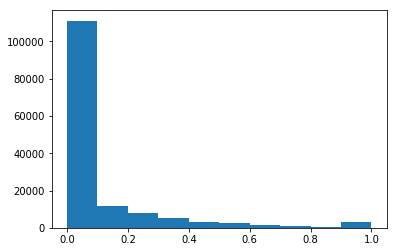

Confusion matrix, without normalization
[[60799  3005  3056]
 [32531  3116 11180]
 [10187  1490 22699]]
Normalized confusion matrix
[[0.90934789 0.04494466 0.04570745]
 [0.69470605 0.06654281 0.23875115]
 [0.29634047 0.04334419 0.66031534]]


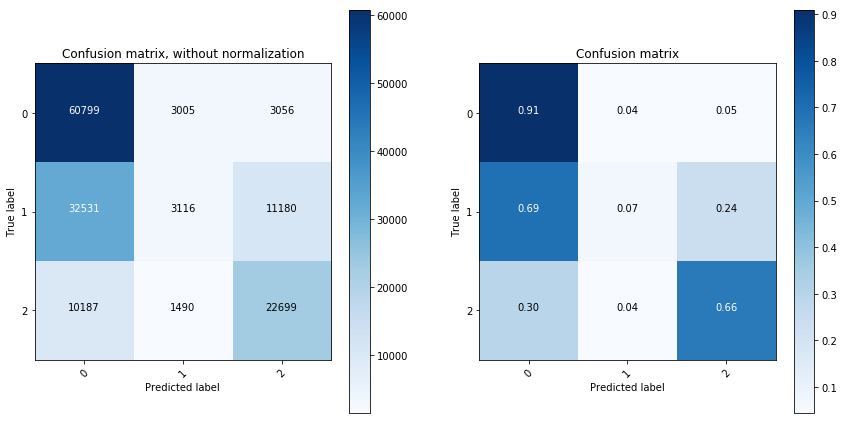

In [116]:
TFIDF_pred_labels = get_labels(TFIDF_preds, ths=[0.01, 0.1])
print("overall accuracy:", float(np.where(TFIDF_pred_labels==dev_pairs['label'])[0].shape[0])/len(TFIDF_pred_labels))
plt.figure()
plt.hist(TFIDF_preds)
plt.show()
eval_plot(TFIDF_pred_labels, dev_pairs['label'])

### avg word embedding

In [45]:
avg_embed_preds = predict(dev_pairs['s1'], dev_pairs['s2'], ptype="avg_embedding_predict")

100%|██████████| 148063/148063 [02:19<00:00, 1063.90it/s]


overall accuracy: 0.5727156683303729


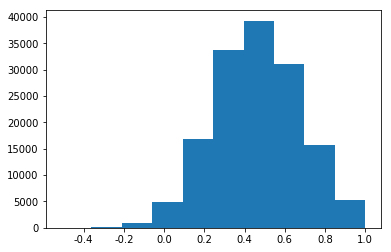

Confusion matrix, without normalization
[[53292  5272  8296]
 [24951  5259 16617]
 [ 5989  2140 26247]]
Normalized confusion matrix
[[0.7970685  0.07885133 0.12408017]
 [0.53283362 0.112307   0.35485938]
 [0.17422039 0.06225273 0.76352688]]


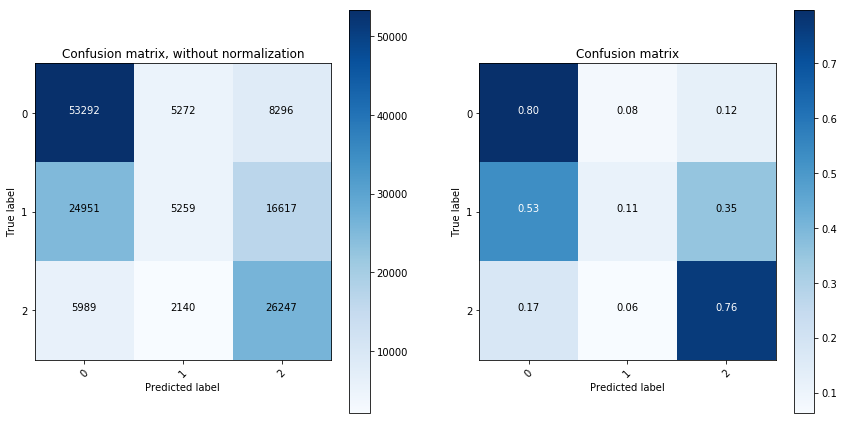

In [115]:
avg_embed_pred_labels = get_labels(avg_embed_preds, ths=[0.5, 0.55])
print("overall accuracy:", float(np.where(avg_embed_pred_labels==dev_pairs['label'])[0].shape[0])/len(avg_embed_pred_labels))
plt.figure()
plt.hist(avg_embed_preds)
plt.show()
eval_plot(avg_embed_pred_labels, dev_pairs['label'])

### IDF word embedding

In [50]:
IDF_embed_preds = predict(dev_pairs['s1'], dev_pairs['s2'], ptype="IDF_embedding_predict")

100%|██████████| 148063/148063 [02:23<00:00, 1032.21it/s]


0.5529335485570331


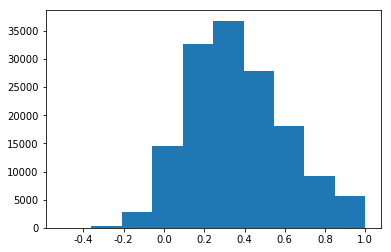

Confusion matrix, without normalization
[[45174 11673 10013]
 [15982  8856 21989]
 [ 3432  3105 27839]]
Normalized confusion matrix
[[0.67565061 0.17458869 0.14976069]
 [0.34129882 0.18912166 0.46957952]
 [0.0998371  0.09032465 0.80983826]]


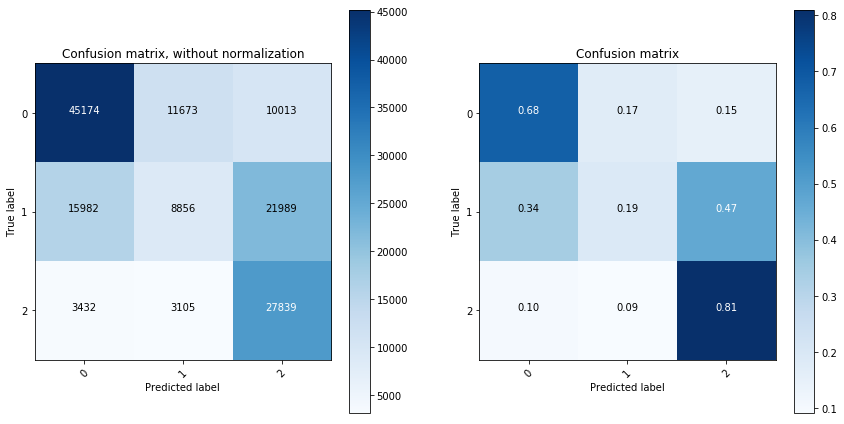

In [114]:
IDF_embed_pred_labels = get_labels(IDF_embed_preds, ths=[0.3, 0.4])
print( float(np.where(IDF_embed_pred_labels==dev_pairs['label'])[0].shape[0])/len(IDF_embed_pred_labels))
plt.figure()
plt.hist(IDF_embed_preds)
plt.show()
eval_plot(IDF_embed_pred_labels, dev_pairs['label'])

### InferSent Train

In [470]:
from torch import optim

def adjust_learning_rate(optimizer):
    print("learning rate decay by half")
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
        param_group['lr'] /= 2
        print(param_group['lr'])

def train_small_epoch(epoch=1, batch_size=64, dpout_embed=0.2, percent=0.1, verbose=False):
    all_costs = []
    tot_costs = []
    logs = []
    correct = 0.0
    nli_net.train()
    permutation = np.random.choice(np.random.permutation(len(train_pairs['s1'])), int(percent*len(train_pairs['s1'])))
    s1 = train_pairs['s1'][permutation]
    s2 = train_pairs['s2'][permutation]
    target = train_pairs['label'][permutation]
    
    for i in range(0, len(s1), batch_size):
#         s1_batch, s1_len = get_batch(s1[i:i+batch_size], wv, default_wv, dpout_embed)
#         s2_batch, s2_len = get_batch(s2[i:i+batch_size], wv, default_wv, dpout_embed)
        
        s1_batch, s1_len= get_inds_batch(s1[i:i+batch_size], word2ind)
        s2_batch, s2_len= get_inds_batch(s2[i:i+batch_size], word2ind)
    
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i:i+batch_size])).cuda()
        
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
        
        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()

        # loss
        loss = loss_fn(output, tgt_batch)
        all_costs.append(loss.item())
        tot_costs.append(loss.item())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and len(all_costs) == 10:
            logs.append('{0};  loss: {1};  accuracy train: {2}'.format(i, 
                            round(np.mean(all_costs), 2), round(100.*correct/(i+k), 2)))
            print(logs[-1])
            all_costs = []
            
    train_acc = round(100 * correct/len(s1), 2)
    train_loss = round(np.mean(tot_costs), 2)
    return train_loss, train_acc  

In [474]:
config_nli_model = {
    'n_words'        :  word_embed_matrix.shape[0],
    'word_emb_dim'   :  300,
    'enc_lstm_dim'   :  256,
    'num_layer'   :  1,
    'dpout_model'    :  0,
    'dpout_fc'       :  0.2,
    'fc_dim'         :  256,
    'bsize'          :  64,
    'n_classes'      :  3,
    'pool_type'      :  'max',
    'encoder_type'   :  'GRUEncoder',
    'use_cuda'       :  True,
    'dpout_embed'    :  0.0,
    'embed_freeze'   :  True,
    'embed_matrix'   :  word_embed_matrix,
    'weight_decay'   :  1e-5,
    "final_hidden_attention": True,
}

In [475]:
torch.manual_seed(10)
np.random.seed(10)

### Train Playground

In [476]:
from models import *
nli_net = NLINet(config_nli_model)
parameters = filter(lambda p: p.requires_grad, nli_net.parameters())
print(nli_net)

# loss 
weight = torch.FloatTensor(3).fill_(1)
loss_fn = nn.CrossEntropyLoss(weight=weight)

# optimizer
optimizer = optim.Adam(parameters, lr=0.005, weight_decay=config_nli_model['weight_decay'])

# cuda 
torch.cuda.manual_seed(10)
torch.cuda.set_device(0)
nli_net.cuda()
loss_fn.cuda()

NLINet(
  (embed): Embedding(5769, 300)
  (embed_dropout): Dropout(p=0.0)
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 256, bidirectional=True)
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.2)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax()
  )
)


CrossEntropyLoss()

In [477]:
percent = 0.01
batch_size = 64
dpout_embed = 0.2

nli_net.train()
permutation = np.random.choice(np.random.permutation(len(train_pairs['s1'])), int(percent*len(train_pairs['s1'])))
s1 = train_pairs['s1'][permutation]
s2 = train_pairs['s2'][permutation]
target = train_pairs['label'][permutation]
prev_loss = float('inf')
tot_loss = []

for epoch in tqdm(range(5)):
    for stidx in range(0, len(s1), batch_size):
        s1_batch, s1_len= get_inds_batch(s1[stidx:stidx+batch_size], word2ind)
        s2_batch, s2_len= get_inds_batch(s2[stidx:stidx+batch_size], word2ind)

        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[stidx:stidx+batch_size])).cuda()
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))


        pred = output.data.max(1)[1]
        
        # loss
        loss = loss_fn(output, tgt_batch)
        tot_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
    #     print(nn.utils.clip_grad_norm_(nli_net.parameters(), 1.0, norm_type=2))
        optimizer.step()
    #     for p in parameters:
    #         print(p.grad.norm())
    mean_loss = np.mean(tot_loss)
    print(mean_loss, prev_loss)
    if prev_loss-mean_loss<1e-3:
        adjust_learning_rate(optimizer)
    prev_loss = mean_loss


 20%|██        | 1/5 [00:14<00:58, 14.52s/it]

0.8975451113903417 inf



 40%|████      | 2/5 [00:29<00:43, 14.52s/it]

0.8660630383322724 0.8975451113903417



 60%|██████    | 3/5 [00:43<00:28, 14.45s/it]

0.8474433561869427 0.8660630383322724



 80%|████████  | 4/5 [00:57<00:14, 14.41s/it]

0.8346066511837782 0.8474433561869427



100%|██████████| 5/5 [01:11<00:00, 14.39s/it]


0.8253824643329182 0.8346066511837782


### Find Best Parameters

In [469]:
lrs = []
hidden_sizes = []
train_losses = []
weight_decays = []
train_accs = []
for i in range(100):
    lr = 10**np.random.uniform(-1, -4.5)
    hidden_size = np.random.choice([128, 256, 512])
    weight_decay = 10**np.random.uniform(-4, -8)
    lrs.append(lr)
    hidden_sizes.append(hidden_size)
    weight_decays.append(weight_decay)
    
    config_nli_model['enc_lstm_dim'] = int(hidden_size)
    config_nli_model['weight_decay'] = weight_decay
    
    from models import *
    nli_net = NLINet(config_nli_model)
    parameters = filter(lambda p: p.requires_grad, nli_net.parameters())

    optimizer = optim.Adam(parameters, lr=lr, weight_decay=weight_decay)
    weight = torch.FloatTensor(3).fill_(1)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    
    nli_net.cuda()
    loss_fn.cuda()
    for i in range(10):
        train_loss, train_acc  = train_small_epoch(1, batch_size=64, dpout_embed=0.2, percent=0.01)
        print("lr: {};  hidden_size: {};  train_loss: {};  train_acc: {}".format(round(lr,5), hidden_size, train_loss, train_acc))
    print("-"*100)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

lr: 5e-05;  hidden_size: 256;  train_loss: 1.03;  train_acc: 49.07


KeyboardInterrupt: 

### InferSent Eval

In [295]:
model_name = "model_5"
params = pickle.load( open(os.path.join("saved_model", model_name, "config.pickle"), "rb"))
word2ind = pickle.load( open(os.path.join(data_path,'word2ind.pickle'), "rb") )
ind2word = pickle.load( open(os.path.join(data_path,'ind2word.pickle'), "rb") )
word_embed_matrix = build_word_embed_matrix(word2ind, pretrained_wordVec="w2v-model.txt")

Found (5211/5768) words with w2v vectors


In [296]:
config_nli_model = {
    'n_words'        :  word_embed_matrix.shape[0],
    'word_emb_dim'   :  word_embed_matrix.shape[1],
    'enc_lstm_dim'   :  params.enc_lstm_dim,
    'num_layer'      :  params.num_layer,
    'dpout_model'    :  params.dpout_model,
    'dpout_fc'       :  params.dpout_fc,
    'fc_dim'         :  params.fc_dim,
    'bsize'          :  params.batch_size,
    'n_classes'      :  params.n_classes,
    'pool_type'      :  params.pool_type,
    'encoder_type'   :  params.encoder_type,
    'use_cuda'       :  params.use_cuda,
    'dpout_embed'    :  params.dpout_embed,
    'embed_freeze'   :  params.embed_freeze==1,
    'embed_matrix'   :  word_embed_matrix,
    "final_hidden_attention": params.final_hidden_attention,
}


In [297]:
torch.cuda.set_device(0)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [298]:
nli_net = NLINet(config_nli_model)
nli_net.load_state_dict(torch.load(os.path.join("saved_model", model_name, model_name)))
nli_net.cuda()
print(nli_net)
print(config_nli_model)

NLINet(
  (embed): Embedding(5769, 300)
  (embed_dropout): Dropout(p=0.2)
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 256, bidirectional=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.4)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax()
  )
)
{'n_words': 5769, 'word_emb_dim': 300, 'enc_lstm_dim': 256, 'num_layer': 1, 'dpout_model': 0.0, 'dpout_fc': 0.4, 'fc_dim': 256, 'bsize': 64, 'n_classes': 3, 'pool_type': 'max', 'encoder_type': 'GRUEncoder', 'use_cuda': True, 'dpout_embed': 0.2, 'embed_freeze': False, 'embed_matrix': matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.04624826, -0.04238107, -0.01844234, ..., -0.06296446,
         -0.04352998, -0.11233711],
        [-1.246123  , -0.86176   , -0.680579  , ..., -0.799309  ,
          0.309729  ,  1.211641  ],
        ...,
    

In [299]:
eval_labels = evaluate(dev_pairs, bsize = 64)


 86%|████████▌ | 1979/2314 [00:33<00:05, 58.86it/s]


100%|██████████| 2314/2314 [00:39<00:00, 58.82it/s]


0.9176904425818739
Confusion matrix, without normalization
[[63952  2167   741]
 [ 3549 41084  2194]
 [ 1535  2001 30840]]
Normalized confusion matrix
[[0.95650613 0.03241101 0.01108286]
 [0.07578961 0.87735708 0.04685331]
 [0.04465325 0.05820922 0.89713754]]


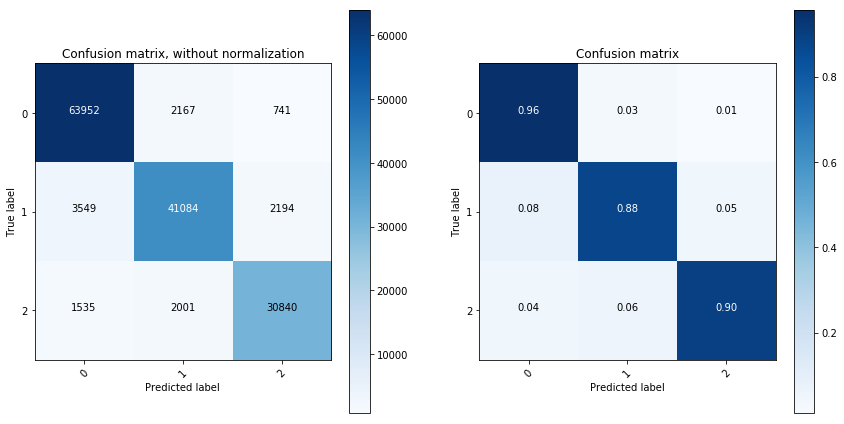

In [300]:
print( float(np.where(eval_labels==dev_pairs['label'])[0].shape[0])/len(eval_labels))
eval_plot(eval_labels, dev_pairs['label'])

## Error Analysis

In [143]:
# inds = np.where((eval_labels==2) & (dev_pairs['label']==2))[0]
# for ind in inds:
#     print(dev_pairs['s1'][ind],"  ", dev_pairs['s2'][ind])

In [141]:
s1 = "哪款 热水器 好"
s2 = "能 推荐 一个 热水器"
s3 = "能 推荐 一个 电视"
s4 = "我 想买 热水器"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))

2
2
2


In [125]:
s1 = "我 想 把 地址 改 到 北京"
s2 = "地址 能 改 到 北京"
s3 = "地址 能 改 到 天津"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

2
2


In [126]:
s1 = "我 把 地址 改 到 北京"
s2 = "能 推荐 热水器"
s3 = "我 退货"
s4 = "可以 改 退货 地址"
s6 = "我 改 退货 地址"

print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))
print(pred_onePair([s1], [s6]))
print(pred_onePair([s4], [s6]))

0
2
0
2
2


In [144]:
inds = np.where((eval_labels==0) & (dev_pairs['label']==2))[0]
for ind in inds:
    print(dev_pairs['s1'][ind],"\t", dev_pairs['s2'][ind])

券 怎么 没有 到账 	 买 苏泊尔 返 100 是 返 问地点 账户 怎么 没有
券 怎么 没有 到账 	 怎么 现在 没有 返回
一 小 时 太 慢 我 要 问时间 前 买 问时间 到 	 有 什么 券 送 时 送给 我
我 买 参加 问时间 退换货 365天 换 不 要 看 	 365
芳村 能 到 	 在 上海 买 能 到 江苏 泰州
芳村 能 到 	 负责 搬 楼
我 手机 问时间 能 送 单 	 有 什么 券 送 时 送给 我
我 手机 问时间 能 送 单 	 我 壳 问时间 发还 有 商品
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 通电 指示灯 不亮 怎么 处理
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 有 人 来 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 要 保修 怎 办
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 你 卡 现在 插 手机 里 不显示
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 海外购 商品 故障 怎么 保修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 小米 平衡 车 不能 激活 是什么 原因
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 商品 突然 做 不了 饭
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 报 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 买 海尔 冰箱 故障 怎么 弄 修 货
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 怎么 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 问时间 买 手机 为什么 再 关机 状态 下 不能 充满 格
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 售后 怎么 安排
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 显示屏 不能 说 安排 维修 师傅 上门
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 台 商品 怎么 突然 不能 单 脱水
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 去年 买 电饭煲 故障 去 问地点 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 打印机 卡纸 要 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 前 问时间 买 热

问时间 到 全部 是 烂 和 商家 联系 不 回 	 现在 没有 办法 充电
我 冰箱 师傅 已经 开 好 单 要 怎么 退换货 	 因为 铜管 616 不能 安装 换 台 612 铜管 商品
要 安装 时 怎么 弄 	 有 物流 师傅 信息
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 现在 再 进 一台 能 原来 价格
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 能 在 便宜点
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 赠品 不要 价格 能 优惠
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 都 家 买 什么 优惠 不
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 你 便宜点
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 你 家 有 优惠
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 再 有 优惠
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 便宜点
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 能 给我 优惠
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 你 不能 便宜点
我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到 	 手机 能 在 便宜点
我 没有 看到 有 退换货 选项 	 因为 铜管 616 不能 安装 换 台 612 铜管 商品
也是 从 最近 地方 发货 	 你 发货 是 在 六安 发
也是 从 最近 地方 发货 	 问地点 发送
不是 满 1000 返 券 怎么 没有 	 怎么 现在 没有 返回
吸尘器 吸力 大 	 在吗 p 20 用
吸尘器 吸力 大 	 漫步者 商品 华硕 都 不能用
吸尘器 吸力 大 	 该机 没有 负责 和 鼠标
问时间 问时间 订单 问时间 问时间 发货 什么 情况 	 我 现在 很 老 火 家里 要 来 老人 看病 天气 热 都 着 商品 现在 糟心
问时间 问时间 订单 问时间 问时间 发货 什么 情况 	 怎么 没有 从 郑州 发出
大米 刚 到 数量 不够 我 定 5袋 箱 里 只有 4袋 	 我 热水器 安装 时 没有 根 水

该机 没有 负责 和 鼠标 	 油烟机 风 管 直径 多少
该机 没有 负责 和 鼠标 	 我 是否 高 清 智能 语音
该机 没有 负责 和 鼠标 	 评价 里 有 说 本 款 商品 不 带 插头
该机 没有 负责 和 鼠标 	 乐 2 prox 620 手机 标准 是 移动 联通 电信 三 卡 都 用
该机 没有 负责 和 鼠标 	 3501 滤芯 能 用
该机 没有 负责 和 鼠标 	 油烟机 开 孔 尺寸 是 多少
该机 没有 负责 和 鼠标 	 商品 参数 包装 参数
该机 没有 负责 和 鼠标 	 包装 尺寸 多大
我 刚 买 商品 怎么 是 从 武汉 发 	 问地点 发送
忽然 没反应 是 	 灰色 没事 黑色 扁
忽然 没反应 是 	 商品 安装 好 开 不了
我 买 手机 现在 信号 特别 差 	 商品 安装 好 开 不了
我 买 手机 现在 信号 特别 差 	 可是 没反应
因为 商品 降 	 是否 能 议价
而且 我 刚 到 是 便宜 201元 怎么 解释 	 差价 返还 到 问地点
而且 我 刚 到 是 便宜 201元 怎么 解释 	 贵就赔 怎么 还不 处理
我 订单 货 退换货 货款 没有 退换货 	 再 不 退款 我 要 投诉
我 在 支付 时 不能 输入 银行卡 姓名 	 支付 时 说 系统 繁忙
我 在 支付 时 不能 输入 银行卡 姓名 	 支付 页面 跳 转 不 出 来 怎么
我 在 支付 时 不能 输入 银行卡 姓名 	 我 怎么用 不 成银联
我 在 支付 时 不能 输入 银行卡 姓名 	 怎么 不能 点 击 买
确定 能 物流 	 在 上海 买 能 到 江苏 泰州
确定 能 物流 	 能 保存 问地点 都是 送
找 不到 贵就赔 问地点 	 问时间 问时间 买 159 问时间 拼购 149
问地点 写 主城区 系统 说 问时间 能到 	 我 壳 问时间 发还 有 商品
问地点 写 主城区 系统 说 问时间 能到 	 现在 买 问时间 开始
问地点 写 主城区 系统 说 问时间 能到 	 要 确保 问时间 给我 发货
问地点 写 主城区 系统 说 问时间 能到 	 额 慢 没有 发货
问时间 到货 	 我 壳 问时间 发还 有 商品
问时间 到货 	 现在 下 单一 定 要 九号 能 取
怎么 申请 解冻 易付宝 账户 	 

再 不 退款 我 要 投诉 	 为什么 取消 订单 一 周 还是 没有 到 退款
你 负责 送 是 直接 送 上门 还是 只 到 楼下 	 在 上海 买 能 到 江苏 泰州
你 负责 送 是 直接 送 上门 还是 只 到 楼下 	 含山县 关镇 能 到
我 换 手机 屏幕 价格 不 贵 	 保修 范围
我 换 手机 屏幕 价格 不 贵 	 在 保修 问时间 内 运费 谁 出
我 到 现在 都 没收到 东西 	 我 现在 很 老 火 家里 要 来 老人 看病 天气 热 都 着 商品 现在 糟心
我 到 现在 都 没收到 东西 	 怎么 没有 从 郑州 发出
直接 从 店 发货 	 问地点 发送
我 平台 卖 手机 押金 是 多少 	 你 这边 入 驻 成为 商家 要 多少 押金
我 平台 卖 手机 押金 是 多少 	 商家入 驻 要 多少 押金
我 买 脆 枣 和 你 描述 不一样 	 冰箱 页面 介绍 是 1级 到 是 2级 你 虚假 宣传
我 搞不懂 你 苏宁发 什么 物流 	 苏宁配
我 搞不懂 你 苏宁发 什么 物流 	 我 看 是 你 物 流速 度
我 想要 在 买 一台 但是 要 过 问时间 能 买 	 还是 问时间 到不了
我 想要 在 买 一台 但是 要 过 问时间 能 买 	 我 快件 问时间 到不了
我 想要 在 买 一台 但是 要 过 问时间 能 买 	 有 什么 券 送 时 送给 我
我 想要 在 买 一台 但是 要 过 问时间 能 买 	 到 潍坊 问时间
我 想要 在 买 一台 但是 要 过 问时间 能 买 	 苏宁 物流 问时间 能 到
我 想要 在 买 一台 但是 要 过 问时间 能 买 	 不能 发货
我 要 问时间 到 上门 	 能 延期 问时间
我 要 问时间 到 上门 	 苏宁 苏宁 物流 能 放在 门卫 代收
我 要 问时间 到 上门 	 刚 买 两台 热水器 延迟 预约 交货 怎么
我 要 问时间 到 上门 	 不想 到
我 要 问时间 到 上门 	 都是 推迟 1个月
我 要 问时间 到 上门 	 把 发货 时 在 修改 下
我 要 问时间 到 上门 	 热水器 能 往后 更改 一个月 送
你 人员 来 时 不 提前 联系 下 	 你 物流 不是 先验 货 再 签收
你 人员 来 时 不 提前 联系 下 	 物流 联系 来

In [145]:
s1 = "什么 时候 退款 到账"
s2 = "怎么 还不 退款"
s3 = "怎么 还不 退款 烂 透"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

2
1


In [146]:
s1 = "买的 空调 可以 晚 几天 送"
s2 = "怎么 更改 送货 时间"
s3 = "什么 时候 送"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

0
2


In [147]:
s1 = "货 我 已经 收到 我 不知道 怎么 签收"
s2 = "在哪 确认 收货"
s3 = "支持 开箱 验 机"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

1
1


In [148]:
s1 = "建议 你 可以 提前 拨打 一下 预约 安装"
s2 = "可以 预约 收货 当天 安装 吗 "
s3 = "下单 可以 确认 安装 服务 下单 后 可 通过 以下 链接 确认 服务 信息 或 预约 更改 服务 时间 商家 安装 问题 请 优先 联系 商家 客服"
s4 = "你 帮 我 看看 这 快递 到 哪 了 "
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))

2
2
0


## Test Set

In [313]:
def nn_score(df):
    print("caculating neural netowrk prediction ...")
    df['nn_score'] = df[['q_tokens', 'similar_q_tokens']].apply(lambda x: score_onePair([x[0]],[x[1]]), axis=1)
    df['nn_roundScore'] = df['nn_score'].apply(lambda x: round(x, 3))

def cos_score(df):
    print("calculating cosine similarity of encoding vector ...")
    df['cos_score'] = df[['q_tokens', 'similar_q_tokens']].apply(lambda x: cosScore_onePair([x[0]],[x[1]]), axis=1)
    df['cos_roundScore'] = df['cos_score'].apply(lambda x: round(x, 3))

def result_label(df):
    nn_idx = df.groupby('q_id')['nn_score'].transform(max) == df['nn_score']
    sm_idx = df.groupby('q_id')['score'].transform(max) == df['score']
    cos_idx = df.groupby('q_id')['cos_score'].transform(max) == df['cos_score']
    
    nn_label = df.loc[nn_idx].groupby('q_id')[['similar_q', 'similar_q_tokens', 'standard_q', 'nn_roundScore']].first()
    sm_label = df.loc[sm_idx].groupby('q_id')[['similar_q', 'similar_q_tokens','standard_q', 'score']].first()
    cos_label = df.loc[cos_idx].groupby('q_id')[['similar_q', 'similar_q_tokens','standard_q', 'cos_roundScore']].first()
    
    q = df.groupby('q_id')[['q', 'expect_q', 'q_tokens']].first()
    result = pd.concat( [q, sm_label, nn_label, cos_label], axis=1)
    result.columns = ['q', 'expect_q', 'q_tokens', 
                      'sm_similar_q', 'sm_similar_q_tokens', 'sm_standard_q', 'sm_score', 
                      'nn_similar_q', 'nn_similar_q_tokens', 'nn_standard_q', 'nn_score',
                     'cos_similar_q', 'cos_similar_q_tokens', 'cos_standard_q', 'cos_score']
    return result

def major_vote(s_ls):
    count = collections.defaultdict(int)
    for s in s_ls:
        count[s] += 1
    sorted_count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)
    if sorted_count[0][1]>1:
        return sorted_count[0][0]
    else:
        return s_ls[-1]
    
def major_label(df):
    df['major_standard_q'] = df[['sm_standard_q', 'nn_standard_q', 'cos_standard_q']].apply(lambda x: major_vote(x),axis=1)
    
def q_num_tokens(df):
    df['q_num_tokens'] = df['q_tokens'].apply(lambda x: len(x.strip().split()))

In [181]:
# test_df = pd.read_csv( os.path.join(data_path, "questions_test_tokenized.csv"))
# nn_score(test_df)
# cos_score(test_df)
# test_df.to_csv("questions_test_pred_"+model_name+".csv", index=False, encoding='utf-8-sig')

In [223]:
test_df = pd.read_csv("questions_test_pred_"+model_name+".csv")

In [236]:
test_df[test_df.actual_q.isnull()]

,q_id,q,q_tokens,score,similar_q,similar_q_tokens,standard_q,expect_q,actual_q,nn_score,nn_roundScore,cos_score,cos_roundScore
1349,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.3068,买的抽油烟机修改延迟发货,买 抽油烟机 修改 延迟 发货,怎么更改送货时间,怎么更改送货时间,NaN,1.000000e+00,1.000,0.583087,0.583
1350,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.3332,延迟送货，要在哪里修改,延迟 物流 要 问地点 修改,怎么更改送货时间,怎么更改送货时间,NaN,1.000000e+00,1.000,0.510836,0.511
1351,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.2099,我只是问问我可以买20瓶吗？,我 只是 我 能 买 20瓶,可以买多少,怎么更改送货时间,NaN,9.254741e-22,0.000,-0.028652,-0.029
1352,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.2452,我申请的任性贷一个星期了，怎么还在审核中,我 申请 任性贷 星期 怎么 在 审核,任性贷开通需要多久,怎么更改送货时间,NaN,4.025978e-08,0.000,0.168252,0.168
1353,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.1298,那你们的贵就赔只是个幌子,你 贵就赔 只是 幌子,为什么无法补差,怎么更改送货时间,NaN,2.131130e-16,0.000,0.127470,0.127
1354,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.2990,怎么去修改商户的基本业务信息,怎么 去 修改 商户 基本 业务 信息,如和修改基本业务信息,怎么更改送货时间,NaN,9.238413e-14,0.000,0.230823,0.231
1355,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.1139,师傅只是送货上门吗,师傅 只是 送货上门,送货安装是否同步进行,怎么更改送货时间,NaN,9.055747e-05,0.000,0.207153,0.207
1356,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.1169,只是送货，不安装吗,只是 物流 不 安装,送货安装是否同步进行,怎么更改送货时间,NaN,8.202758e-09,0.000,0.189789,0.190
1357,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.1026,只是想注销任性付亲,只是 注销 任性付,任性付如何注销,怎么更改送货时间,NaN,5.482336e-13,0.000,0.128706,0.129
1358,84,这款我去修改了怎么只是延迟一个星期,我 去 修改 怎么 只是 延迟 星期,0.3831,我想申请延迟收货，怎么办,我 申请 延迟 到 怎么,怎么更改送货时间,怎么更改送货时间,NaN,1.000000e+00,1.000,0.608556,0.609


In [231]:
display(test_df.head())

,q_id,q,q_tokens,score,similar_q,similar_q_tokens,standard_q,expect_q,actual_q,nn_score,nn_roundScore,cos_score,cos_roundScore
0,1,在哪里领券,问地点 领 券,1.0000,在哪里领券,问地点 领 券,在哪里领券,在哪里领券,在哪里领券,1.0,1.0,1.000000,1.000
1,1,在哪里领券,问地点 领 券,0.7684,请问领劵的地方在哪里,领 券 地方 问地点,在哪里领券,在哪里领券,在哪里领券,1.0,1.0,0.756595,0.757
2,1,在哪里领券,问地点 领 券,0.7698,领劵的页面在哪里,领 券 页面 问地点,在哪里领券,在哪里领券,在哪里领券,1.0,1.0,0.785753,0.786
3,1,在哪里领券,问地点 领 券,0.8675,在哪里可以领劵啊,问地点 能 领 券,在哪里领券,在哪里领券,在哪里领券,1.0,1.0,0.958488,0.958
4,1,在哪里领券,问地点 领 券,1.0000,劵在哪里领,券 问地点 领,在哪里领券,在哪里领券,在哪里领券,1.0,1.0,0.750119,0.750


In [314]:
test_result_df = result_label(test_df)
major_label(test_result_df)

In [315]:
display(test_result_df.sample(30))

,q,expect_q,q_tokens,sm_similar_q,sm_similar_q_tokens,sm_standard_q,sm_score,nn_similar_q,nn_similar_q_tokens,nn_standard_q,nn_score,cos_similar_q,cos_similar_q_tokens,cos_standard_q,cos_score,major_standard_q
q_id,,,,,,,,,,,,,,,,
119,我的发票可以开专票的吧,怎么开增值税专用发票,我 发票 能 开 增值税发票,能开增值税专用发票吗,能 开 增值税发票,怎么开增值税专用发票,0.5444,这个礼品卡能开增票吗,礼品卡 能 开 增值税发票,苏宁卡可以开发票吗,1.00,我想开专票可以吗,我 开 增值税发票,怎么开增值税专用发票,0.866,怎么开增值税专用发票
899,热水器没装好,安装作业技能差,商品 没有 装 好,热水器是苏宁安装是吧,商品 是 苏 宁安 装 是,怎么预约安装,0.4666,热水器是苏宁安装是吧,商品 是 苏 宁安 装 是,怎么预约安装,1.00,我的空调快点安排给我装好,我 商品 快点 安排 给我 装 好,怎么预约安装,0.704,怎么预约安装
341,分配的北京送货吗,从哪里发货,分配 北京 物流,北京同城配送吗,北京 同 城 物流,从哪里发货,0.6153,苏宁物流会分配到那个快递,苏宁 物流 会 分配 到 物流,送货用什么快递,1.00,苏宁物流会分配到那个快递,苏宁 物流 会 分配 到 物流,送货用什么快递,0.706,送货用什么快递
1598,有什么功效？,商品的功能及包装参数,什么 功效,保健品的功效是什么,保健品 功效 是什么,商品怎么食用的,0.3601,这个吃了后会有什么样的效果呢,吃 会 什么 样 效果,商品怎么食用的,0.97,这个什么年龄段的食用合适,什么 年龄段 食用 合适,商品怎么食用的,0.574,商品怎么食用的
348,还没发走，哪天能到？,什么时候送,没有 发 走 问时间 能到,天津哪天能送到货,天津 哪 天能 到,什么时候送,0.4750,天津哪天能送到货,天津 哪 天能 到,什么时候送,1.00,哪我啥时候能收到货,哪 我 问时间 能 到,什么时候送,0.622,什么时候送
1368,多长时间包换？,商品是30天退货364天换货吗,问时间 负责 换,1年包换？,问时间 负责 换,商品是30天退货，365天换货吗,1.0000,是不是1年包换,是否 问时间 负责 换,商品是30天退货，365天换货吗,1.00,1年包换？,问时间 负责 换,商品是30天退货，365天换货吗,1.000,商品是30天退货，365天换货吗
1934,这个是包邮的吗,运费多少,是 包邮,那就不能包邮了是吗,能 包邮,运费多少,0.6606,请问这个是包邮还是自付邮费的呢,是 包邮 还是 支付 邮费,运费多少,1.00,那就不能包邮了是吗,能 包邮,运费多少,0.871,运费多少
715,刚才取消的订单，我想重新启用,撤回退换货申请,刚才 取消 订单 我 重新 启用,刚才取消的订单，我想重新启用,刚才 取消 订单 我 重新 启用,撤回退换货申请,1.0000,刚才取消的订单，我想重新启用,刚才 取消 订单 我 重新 启用,撤回退换货申请,1.00,刚才取消的订单，我想重新启用,刚才 取消 订单 我 重新 启用,撤回退换货申请,1.000,撤回退换货申请
1091,怎么付不了钱,支付为什么显示失败,怎么 支付 不了 价格,怎么支付不了,怎么 支付 不了,支付为什么显示失败,0.7345,我现在付不了钱,我 现在 支付 不了 价格,支付为什么显示失败,1.00,我现在付不了钱,我 现在 支付 不了 价格,支付为什么显示失败,0.864,支付为什么显示失败


In [366]:
print( (test_result_df.sm_standard_q==test_result_df.expect_q).mean() )
print( (test_result_df.nn_standard_q==test_result_df.expect_q).mean() )
print( (test_result_df.cos_standard_q==test_result_df.expect_q).mean() )
print( (test_result_df.major_standard_q==test_result_df.expect_q).mean() )
print( ( (test_result_df.sm_standard_q==test_result_df.expect_q) | \
        (test_result_df.nn_standard_q==test_result_df.expect_q)  | \
        (test_result_df.cos_standard_q==test_result_df.expect_q)  ).mean() )

0.6462440063931806
0.6350559403303143
0.687266915290357
0.6856686201385189
0.7607884922749067


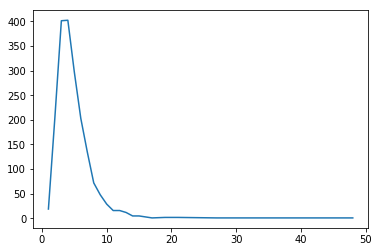

In [228]:
q_num_tokens(test_result_df)
test_result_df.q_num_tokens.value_counts().sort_index().plot()
plt.show()

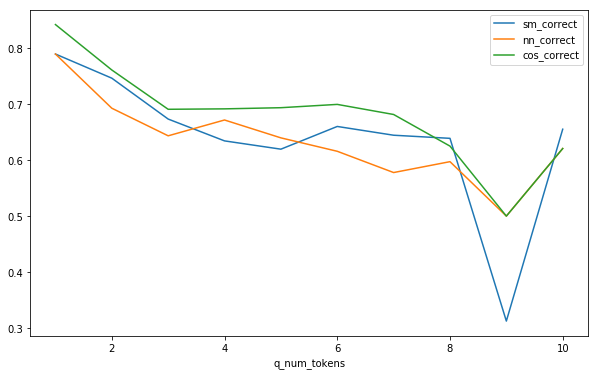

In [229]:
test_result_short_df = pd.DataFrame(test_result_df[test_result_df.q_num_tokens<=10])
test_result_short_df['sm_correct'] = test_result_short_df[['expect_q', 'sm_standard_q']].apply(lambda x: x[0]==x[1], axis=1)
test_result_short_df['nn_correct'] = test_result_short_df[['expect_q', 'nn_standard_q']].apply(lambda x: x[0]==x[1], axis=1)
test_result_short_df['cos_correct'] = test_result_short_df[['expect_q', 'cos_standard_q']].apply(lambda x: x[0]==x[1], axis=1)

plt.figure(figsize=(10,6))
test_result_short_df.groupby('q_num_tokens')['sm_correct'].mean().plot(label='sm_correct')
test_result_short_df.groupby('q_num_tokens')['nn_correct'].mean().plot(label='nn_correct')
test_result_short_df.groupby('q_num_tokens')['cos_correct'].mean().plot(label='cos_correct')
plt.legend()
plt.show()

In [337]:
cos_pred = test_result_df[['q','cos_similar_q','q_tokens','cos_similar_q_tokens','cos_score','cos_standard_q','expect_q']]

In [339]:
cos_pred_wrong = cos_pred[cos_pred.cos_standard_q!=cos_pred.expect_q] 
display(cos_pred_wrong)

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,cos_standard_q,expect_q
q_id,,,,,,,
2,电子发票下载,电子发票下载,电子发票 下载,电子发票 下载,1.000,电子发票怎么下载（无下载按钮怎么办）,电子发票怎么下载(无下载按钮怎么办)
3,可以改开发票么,能不能帮我改为纸质发票,能 更改 开 发票,能 更改 发票,0.933,电子发票和普通纸质发票怎么互换,发票信息是否可以更改
7,我这个订单刚开始支付，活动就取消了,刚下的订单怎么取消,我 订单 刚 开始 支付 优惠 取消,刚 买 订单 怎么 取消,0.568,怎么取消订单,支付为什么显示失败
8,现在支付无法是2899是吗,不能付款是怎么回事,现在 支付 不能 是 2899,不能 支付 是,0.744,支付为什么显示失败,有没有活动，价格能优惠吗
14,纸质发票改成电子发票,帮我电子发票改成纸质发票好吗,发票 更改 成 电子发票,电子发票 更改 成 发票,0.719,电子发票和普通纸质发票怎么互换,发票类型是否可以更改
18,今天收不到货，我就取消订单！,我昨天的订单为什么取消了,问时间 收 不 到货 我 取消 订单,我 问时间 订单 为什么 取消,0.650,订单被自动取消了,查询送货
21,怎么早上还是不能下单了,我想再买，怎么无法下单了,怎么 问时间 还是 不能 买,我 再 买 怎么 不能 买,0.644,可以买多少,支付为什么显示失败
23,我的发票你们给我开哪去了,我想问下你们这发票是怎么开的,我 发票 你 给我 开 哪 去,我 你 发票 是 怎么 开,0.717,怎么开发票,怎么没有发票
29,我的订单31140816719，十天了，都没收到,我10月3日下的订单今天还未收到,我 订单 31140816719 问时间 都 没收到,我 问时间 问时间 买 订单 问时间 没收到,0.795,为什么还没送到,查询送货


In [364]:
ths = np.linspace(0.1,1,20)
accs = []
amounts = []
for th in ths:
    cos_pred_th = cos_pred[cos_pred.cos_score>th]
    acc = (cos_pred_th.expect_q==cos_pred_th.cos_standard_q).mean()
    amount = float(cos_pred_th.shape[0])/cos_pred.shape[0]
    accs.append(acc)
    amounts.append(amount)

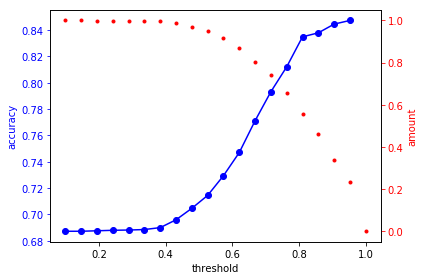

In [365]:
fig, ax1 = plt.subplots()
ax1.plot(ths, accs, 'b-', marker='o')
ax1.set_xlabel('threshold')
ax1.set_ylabel('accuracy', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ths, amounts, 'r.')
ax2.set_ylabel('amount', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [329]:
all_agree_but_wrongpred = test_result_df[ (test_result_df.expect_q!=test_result_df.cos_standard_q) &
                                        (test_result_df.expect_q!=test_result_df.sm_standard_q) &
                                        (test_result_df.expect_q!=test_result_df.nn_standard_q)][['q', 'cos_similar_q', 'q_tokens', 'cos_similar_q_tokens','cos_score', 
                                 'cos_standard_q', 'expect_q']]

In [333]:
display(all_agree_but_wrongpred[all_agree_but_wrongpred.cos_score>0.8])

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,cos_standard_q,expect_q
q_id,,,,,,,
2,电子发票下载,电子发票下载,电子发票 下载,电子发票 下载,1.000,电子发票怎么下载（无下载按钮怎么办）,电子发票怎么下载(无下载按钮怎么办)
32,什么时候到货，今天下单,我得知道什么时间到货才能下单,问时间 到货 问时间 买,我 知道 问时间 到货 能 买,0.840,什么时候送,下单多久发货
55,可以取消拼团订单吗,我要取消拼团,能 取消 拼团 订单,我 要 取消 拼团,0.806,更改拼团状态,怎么取消订单
70,这个订单还能不能退了,我这个订单要退货。,订单 能 退换货,我 订单 要 退换货,0.877,申请退换货,怎么取消订单
87,还没有发货啥意思,你们还没有发货吧,没有 发货,你 没有 发货,0.859,什么时候送,为什么还没送到
94,亲，我的差价什么时候返,这差价给返吧,我 差价 问时间 返,差价 给 返,0.843,怎么申请价保,补差券多久到账
165,拍错了怎么申请退款,我拍错了，怎么退款,拍 错 怎么 申请 退款,我 拍 错 怎么 退款,0.849,申请退换货,如何申请退货
207,物流好慢,苏宁的物流这么慢啊？,物流 慢,苏宁 物流 慢,0.826,为什么还没送到,查询送货
209,商家啥时候发货,商家几天发货,商家 问时间 发货,商家 问时间 发货,1.000,什么时候送,商户商品多久发货


In [369]:
high_confidence_miss = all_agree_but_wrongpred[all_agree_but_wrongpred.cos_score>0.8]
high_confidence_miss.to_excel(os.path.join("result", "high_confidence_miss.xlsx"), index=False, encoding='utf-8-sig')

## Response Sim

In [ ]:
temp_df = pd.read_csv("samples_tokenized.csv", header=None)
temp_df.columns = ['s']

In [67]:
response_df = pd.DataFrame()

In [68]:
response_df['s1'] = temp_df[temp_df.index%2==0].reset_index(drop=True)['s']
response_df['s2'] = temp_df[temp_df.index%2==1].reset_index(drop=True)['s']
response_df['true_label'] = pd.Series(np.append( [2]*16, [[0]*16, [0]*16]).astype(int))

In [72]:
def label_temp(pred, ths):
    if pred<ths[0]:
        return 0
    elif pred<ths[1]:
        return 0
    else:
        return 2
response_df['tfidf_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(TF_IDF_predict(x[0], x[1]), [0.2,0.3]), axis=1)
response_df['avg_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(avg_embedding_predict(x[0],x[1]), [0.3,0.6]), axis=1)
response_df['idf_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(IDF_embedding_predict(x[0], x[1]), [0.3,0.4]), axis=1)
response_df['net_sim'] = response_df[['s1','s2']].apply(lambda x: 2 if test_onePair([x[0]], [x[1]])>=1 else 0, axis=1)

In [79]:
display(response_df)

,s1,s2,true_label,tfidf_sim,avg_embed_sim,idf_embed_sim,net_sim
0,建议 你 可以 提前 拨 打 预约 安装,﻿下单 时 可以 确认 安装 服务 方 下单 通过 以下 链接 确认 服务 信息 预约 更改 服务 时间 商家 安装 问题 优先 联系 商家 客服,2,0,2,2,2
1,﻿不 客气 亲爱 哒,﻿不 客气 亲爱 哒 很 高兴 服务 感谢 对 苏宁 易购 支持 对 我 服务 满意 记 给我 赞,2,2,0,2,0
2,﻿苏宁 配送 商 点 击 自助 修改 配送 信 息,﻿苏宁 发货 可以 自主 修改 指定 送达时间 在线 支付 最多 延迟 45天 货到付款 最多 延迟 7天 点 击 修改 非 苏宁 发货 商品 建议 联系 购买 页面 在线客服 修改,2,0,0,2,2
3,﻿商品 发货 出 库 但是 最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿通过 点 击 查询 物流 苏宁 发货 商品 24小时 内 发货 非 苏宁 发货 商品 48小时 内 发货 实际 送达时间,2,0,2,2,0
4,﻿最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿苏宁 发货 商品 页面 会 显示 预计 到达 时间 提交 订单 时 显示 时间 下单 按照 指定 日期 配送 非 苏宁 发货 商品 下单 在 48小时 内 发货 快递 信息 点 击 查询 当...,2,0,2,2,2
5,﻿苏宁 易购 所 出售 商品 均 正 品行 货 放心 选购,﻿苏宁 易购 所 出售 商品 均 正 品行 货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三包 服务 质量 和 售后服务 与 门店 完全 相同 放心 选购,2,2,2,2,2
6,﻿有 统一 全国 售后服务 正品 质量 保证,﻿苏宁 易购 与 天猫 苏宁 官方 旗舰 店 只是 销售 平台 不同 但 均 苏宁 销售 并发 货 有 统一 全国 售后服务 正品 质量 保证,2,2,2,2,2
7,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务 非 苏宁 发货 商品 建议 联系 面上 在线客服 确定 配送 范围,2,2,2,2,2
8,﻿7天 之 内 只 要 符合 条 件 可以 进行 补差,﻿在 苏宁 易购 购买 自营商品 收货 前 收货 次日 起 七天 内 发现 同一 城市 同一 销售 渠道 商品 售价 低于 购买 时 价格 提交 七天 贵就赔 申请 苏宁 将 依据 本 政策 ...,2,0,0,2,2
9,﻿苏宁 在线 支付 立减 金额 随机 最高 100元 最低 0元,﻿绑定 银行卡 首次 支付 在 提交 订单 支付 时 会有 提示 显示 减价 任性付 支付 立减 立减 金额 随机 最高 100元 最低 0元 立减 0元 说明 此次 优惠 没有 获得 优惠 ...,2,2,2,2,2


In [ ]:
eval_plot(response_df['tfidf_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 6 10]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.375  0.625 ]]


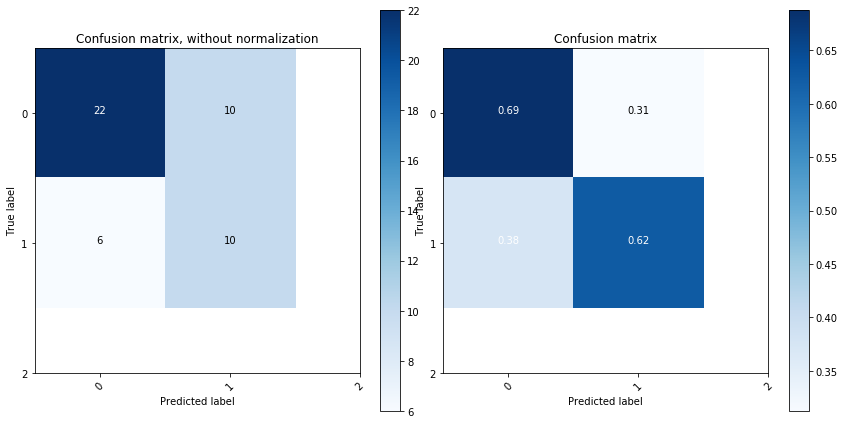

In [251]:
eval_plot(response_df['avg_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[19 13]
 [ 2 14]]
Normalized confusion matrix
[[0.59375 0.40625]
 [0.125   0.875  ]]


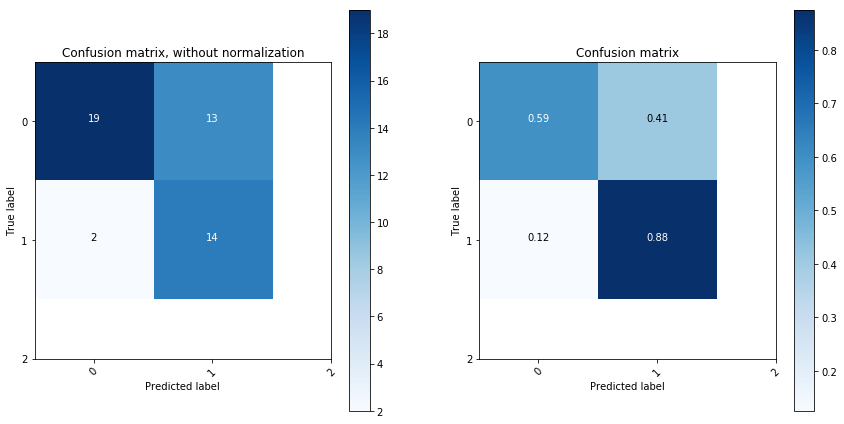

In [77]:
eval_plot(response_df['idf_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 4 12]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.25   0.75  ]]


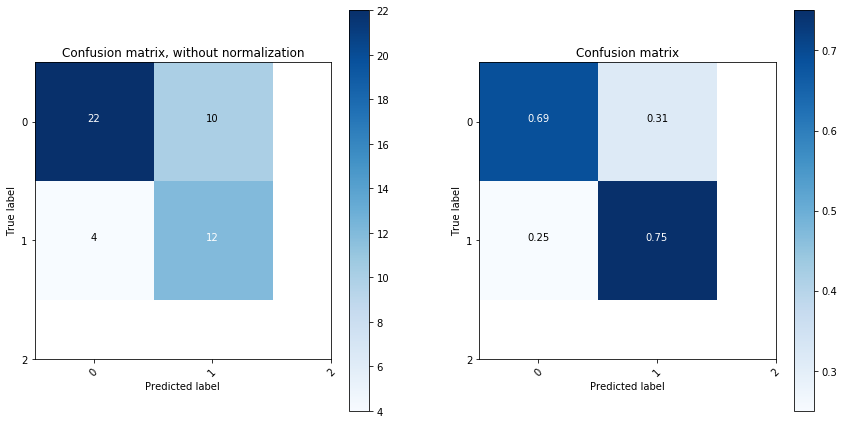

In [78]:
eval_plot(response_df['net_sim'], response_df['true_label'])

In [458]:
s = ['怎么 没有 发货 怎么 没有 发货','问时间 能 发货']
nli_net.eval()
s_batch, s_len = get_inds_batch(s, word2ind)
s_batch = Variable(s_batch.cuda())
out, hidden = nli_net.encode((s_batch, s_len))
# embed = nli_net.encode((s_batch, s_len))

In [459]:
pad_out, lengths= torch.nn.utils.rnn.pad_packed_sequence(out, padding_value=int(0), batch_first=True)

In [460]:
attention = nn.Linear(512,1).cuda()

unnormalize_weight = torch.tanh(torch.squeeze(attention(pad_out), 2)) 
unnormalize_weight = torch.softmax(unnormalize_weight, dim=1)
unnormalize_weight = torch.nn.utils.rnn.pack_padded_sequence(unnormalize_weight, lengths, batch_first=True)
unnormalize_weight, lengths = torch.nn.utils.rnn.pad_packed_sequence(unnormalize_weight, padding_value=0.0, batch_first=True)
print("unnormalize_weight size: %s" % (str(unnormalize_weight.size())))
normalize_weight = torch.nn.functional.normalize(unnormalize_weight, p=1, dim=1)
normalize_weight = normalize_weight.view(normalize_weight.size(0), 1, -1)
weighted_sum = torch.squeeze(normalize_weight.bmm(pad_out), 1)

unnormalize_weight size: torch.Size([2, 6])


In [461]:
unnormalize_weight, lengths

(tensor([[0.1465, 0.1422, 0.1841, 0.1708, 0.1555, 0.2008],
         [0.2036, 0.1551, 0.1760, 0.0000, 0.0000, 0.0000]],
        device='cuda:0', grad_fn=<TransposeBackward0>), tensor([6, 3]))

In [462]:
weighted_sum.size()

torch.Size([2, 512])